In [1]:
# more advanced grid generation in https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py
# more advanced modelbuilding in https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_modelbuilder.py
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import os
    import matplotlib.pyplot as plt
    plt.close('all')
    import dfm_tools as dfmt
    from dfm_tools import modelbuilder as mb
    import hydrolib.core.dflowfm as hcdfm
    import xarray as xr
    import pandas as pd
    import contextily as ctx
    import getpass


In [2]:
# input
model_name = 'Bonaire'
dir_output = './bonaire_model'
path_style = 'unix' # windows / unix
overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
is_geographic = True
crs = 'EPSG:4326'

# domain and resolution
lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
dxy = 0.05

#dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
date_min = '2022-11-01'
date_max = '2022-11-03'
ref_date = '2022-01-01'


In [3]:
# make dirs and list all files
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)
os.listdir(dir_output)

['data']

## Grid generation and refinement with meshkernelpy

Notebook with more details exposed: https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb

>> reading coastlines: 1.30 sec


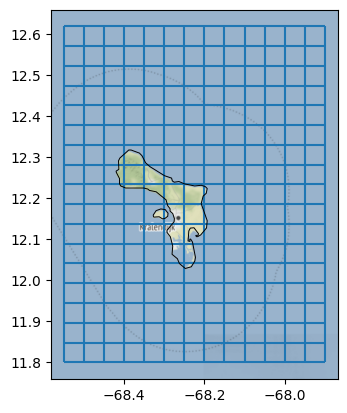

In [4]:
#generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, is_geographic=is_geographic)

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.83 sec


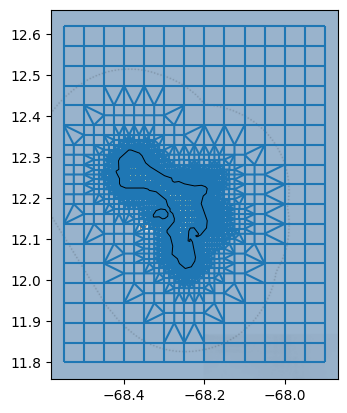

In [5]:
# refine grid

# connect to an example Bonaire cutout of the GEBCO_2021 dataset on OPeNDAP
# alternatively download your own cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
file_gebco = 'https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2021_bonaire/GEBCO_2021_bonaire.nc'
data_bathy_sel = xr.open_dataset(file_gebco)

#refine
min_edge_size = 300 #in meters
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.79 sec
>> reading coastlines: 0.81 sec


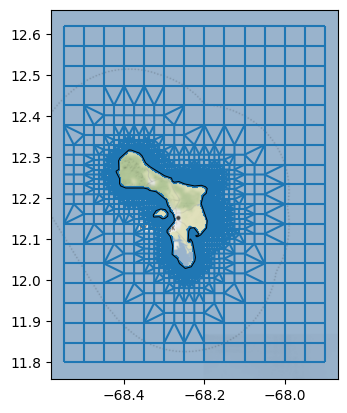

In [6]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.79 sec


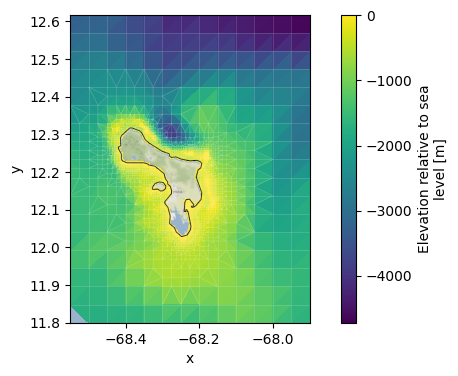

In [7]:
#convert to xugrid, interpolate z-values and write to netcdf
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

#interp bathy
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y).reset_coords(['lat','lon'])
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.elevation.clip(max=10)

#plot bathy and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

#write xugrid grid to netcdf
netfile  = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## Generate boundary polyline and write to file

>> reading coastlines: 0.80 sec


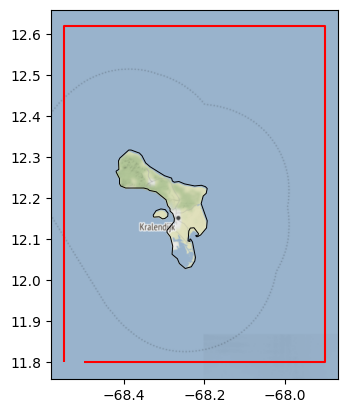

In [8]:
# generate plifile from grid extent
grid_bounds = xu_grid_uds.grid.bounds
pli_polyfile = dfmt.generate_bndpli(lon_min=grid_bounds[0], lon_max=grid_bounds[2], lat_min=grid_bounds[1], lat_max=grid_bounds[3], dlon=dxy, dlat=dxy, name=f'{model_name}_bnd')
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile.save(poly_file)

# plot
polyfile_object = hcdfm.PolyFile(poly_file)
gdf_polyfile = dfmt.PolyFile_to_geodataframe_linestrings(polyfile_object,crs=crs)
ax = gdf_polyfile.plot(edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


## Generate boundary conditions from FES2014 and CMEMS (new ext)

In [9]:
# new ext: initial and open boundary condition
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()

# # interpolate FES2014 tidal components bc file (will not work on binder)
# file_bc_basename = os.path.basename(poly_file).replace('.pli','')
# ForcingModel_object = dfmt.interpolate_tide_to_bc(tidemodel='FES2014', file_pli=poly_file, component_list=None) # tidemodel: FES2014, FES2012, EOT20, GTSM4.1preliminary
# file_bc_out = os.path.join(dir_output,f'tide_{file_bc_basename}_FES2014.bc')
# ForcingModel_object.save(filepath=file_bc_out)
# boundary_object = hcdfm.Boundary(quantity='waterlevelbnd', #the FM quantity for tide is also waterlevelbnd
#                                  locationfile=poly_file,
#                                  forcingfile=ForcingModel_object)
# ext_new.boundary.append(boundary_object)

# CMEMS - download
dir_output_data_cmems = os.path.join(dir_output_data, 'cmems')
os.makedirs(dir_output_data_cmems, exist_ok=True)
for varkey in ['so','thetao','uo','vo','zos']:
    dfmt.download_CMEMS(varkey=varkey,
                        longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                        date_min=date_min, date_max=date_max,
                        dir_output=dir_output_data_cmems, file_prefix='cmems_', overwrite=overwrite)

# CMEMS - boundary conditions file (.bc) (and add to ext_bnd)
list_quantities = ['waterlevelbnd','salinitybnd','temperaturebnd','uxuyadvectionvelocitybnd']
ext_new = mb.cmems_nc_to_bc(ext_bnd=ext_new,
                            refdate_str=f'minutes since {ref_date} 00:00:00 +00:00',
                            dir_output=dir_output,
                            list_quantities=list_quantities,
                            tstart=date_min,
                            tstop=date_max, 
                            file_pli=poly_file,
                            dir_pattern=os.path.join(dir_output_data_cmems,'cmems_{ncvarname}_*.nc'))

#save new ext file
ext_new.save(filepath=ext_file_new,path_style=path_style)


retrieving time range of CMEMS reanalysis and forecast products
opening pydap connection to opendap dataset and opening with xarray: https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1D-m.html
found CMEMS credentials
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_anfc_0.083deg_P1D-m.html
The CMEMS 'analysisforecast' product will be used.
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m.html
xarray subsetting data (variable 'so' and lon/lat extents)
available time range in dataset from 2020-11-01 12:00:00 to 2023-07-21 12:00:00
"cmems_so_2022-10-31.nc" found and overwrite=False, continuing.
"cmems_so_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_so_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_so_2022-11-03.nc" found and overwrite=False, continuing.
opening pydap conne

>> reading coastlines: 0.83 sec
>> reading coastlines: 0.79 sec


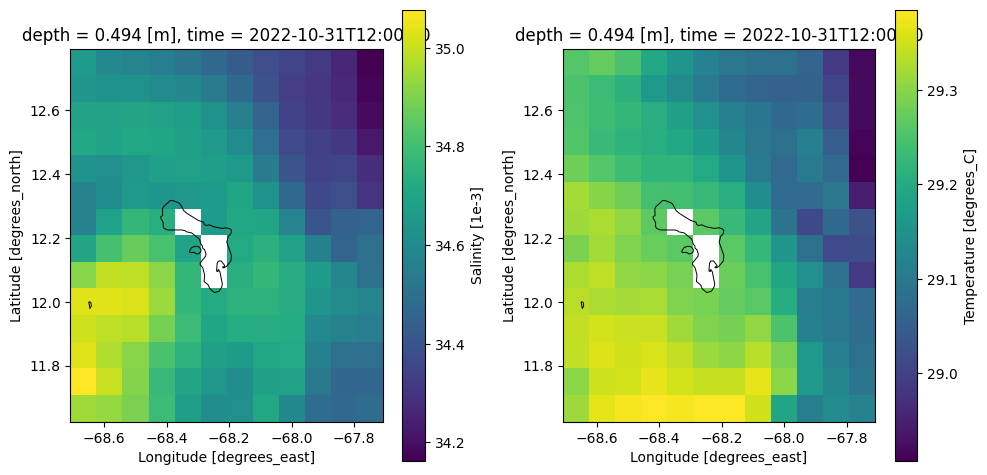

In [10]:
# plot CMEMS data
file_cmems = os.path.join(dir_output,'data','cmems','*.nc')
ds_cmems = xr.open_mfdataset(file_cmems)
ds_cmems

#plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_cmems.so.isel(time=0,depth=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_cmems.thetao.isel(time=0,depth=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


(-3000.0, 0.02965003252029419)

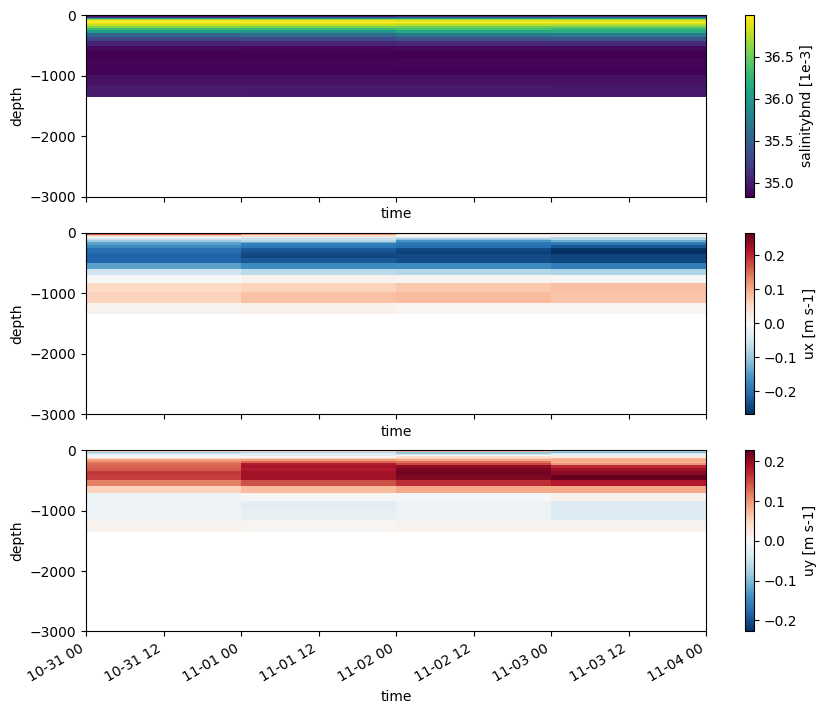

In [11]:
#plot interpolated CMEMS data
file_bc_sal = os.path.join(dir_output,'salinitybnd_Bonaire_CMEMS.bc')
bc_obj_sal = hcdfm.ForcingModel(file_bc_sal)
forcing_xr_sal = dfmt.forcinglike_to_Dataset(bc_obj_sal.forcing[0], convertnan=True)

file_bc_uxuy = os.path.join(dir_output,'uxuyadvectionvelocitybnd_Bonaire_CMEMS.bc')
bc_obj_uxuy = hcdfm.ForcingModel(file_bc_uxuy)
forcing_xr_uxuy = dfmt.forcinglike_to_Dataset(bc_obj_uxuy.forcing[0], convertnan=True)

#plot
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,8))
forcing_xr_sal['salinitybnd'].T.plot(ax=ax1)
forcing_xr_uxuy['ux'].T.plot(ax=ax2)
forcing_xr_uxuy['uy'].T.plot(ax=ax3)
ax1.set_ylim(-3000,None)

## Generate ERA5 meteo forcing (old ext)

In [ ]:
# old ext

# CMEMS - initial condition file
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# ERA5 - download
dir_output_data_era5 = os.path.join(dir_output_data,'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = mb.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                              varkey_list = varlist_list,
                                              dir_data = dir_output_data_era5,
                                              dir_output = dir_output,
                                              time_slice = slice(date_min, date_max))

ext_old.save(filepath=ext_file_old,path_style=path_style)


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_msl_2022-11.nc" found and overwrite=False, continuing.
found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_u10n_2022-11.nc" found and overwrite=False, continuing.
found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_v10n_2022-11.nc" found and overwrite=False, continuing.
found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_chnk_2022-11.nc" found and overwrite=False, continuing.
>> opening multifile dataset of 4 files (can take a while with lots of files): 0.05 sec
>> writing file (can take a while): 

In [ ]:
# plot ERA5 data example
file_era5 = os.path.join(dir_output,'data','ERA5','*.nc')
ds_era5 = xr.open_mfdataset(file_era5)
ds_era5

#plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_era5.u10n.isel(time=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_era5.v10n.isel(time=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


## Generate mdu file

In [ ]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output, f'{model_name}.mdu')
mdu = hcdfm.FMModel()

mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_new

mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

#mdu.output.obsfile = 'stations_obs.xyn'
mdu.output.hisinterval = [60]
mdu.output.mapinterval = [1800]#[86400]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

#%% export model
mdu.save(mdu_file,path_style=path_style)


## Check written files in model directory

In [ ]:
os.listdir(dir_output)